# Melanoma Detection with the ResNet-50 Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


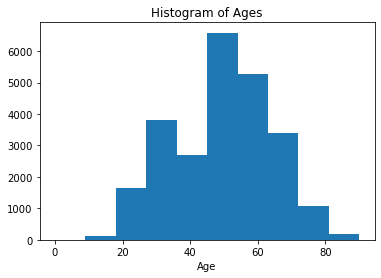

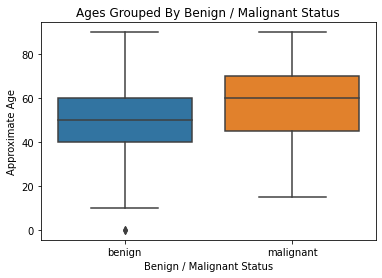

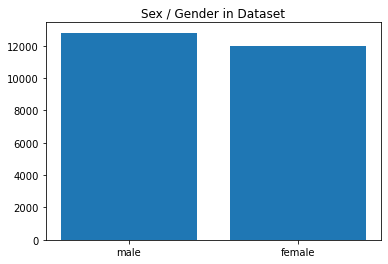

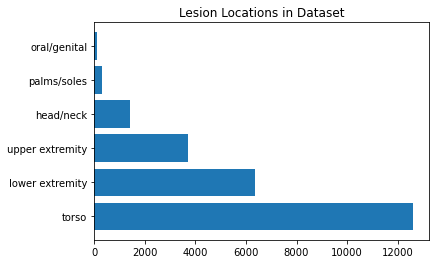

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



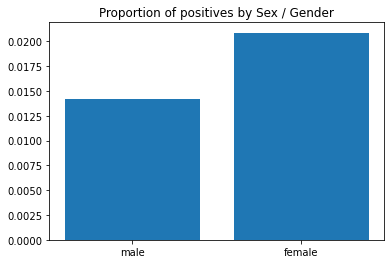



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



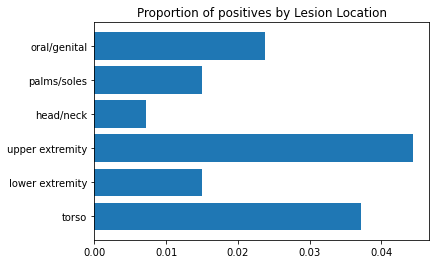

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNet-50 (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 2


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 4

tr_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "train.csv"), 
                            num_samples=5*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [9]:
load_weights = True
create_new_weights = False
PATH = './melanoma_ResNeSt.pth'

# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

if load_weights:
    print('Loading the pre-trained ResNeSt weights.')
    
    # network weights load
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNeSt FC Layer weights.')
    
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    
    

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to /u/home/a/andrewma/.cache/torch/hub/master.zip


Creating new ResNeSt FC Layer weights.


Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [ ]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 12204

        # print every mini-batch
        print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
        print(f'[Epoch {epoch}, Batch {mini_batch % 12204}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 12204 == 0:

            uPATH = f'./saved_weights4/melanoma_ResNeSt_{epoch}e_{mini_batch % 12204}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 448489472
CUDA Memory Allocated: 6869538304
[Epoch 0, Batch 1] Loss: 0.6282063126564026

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.4244

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 2] Loss: 0.6699393391609192

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 3] Loss: 0.6885474920272827

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 4] Loss: 0.7213612049818039

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 5] Loss: 0.724096953868866

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 97] Loss: 0.6600949112901983

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 98] Loss: 0.6585717894593064

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 99] Loss: 0.6607092835686423

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 100] Loss: 0.660706068277359

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 101] Loss: 0.660247534218401

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 102] Loss: 0.6636065133646423

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 103] Loss: 0.6642806182787256

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 104] Loss: 0.6623823356169921

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 105] Loss: 0.6639427582422892

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 106] Loss: 0.6625765786980683

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 107] Loss: 0.6649883523165623

CUDA Memory Allocated: 7312062976
[Epoch 0, 

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 198] Loss: 0.6470053384099343

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 199] Loss: 0.6462492721164645

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 200] Loss: 0.6464801448583603

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 201] Loss: 0.6460289889900246

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 202] Loss: 0.6471551013464975

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 203] Loss: 0.6477201322616615

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 204] Loss: 0.6478605474911484

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 205] Loss: 0.6472479456808509

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 206] Loss: 0.6462381513952051

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 207] Loss: 0.6445492727744982

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 208] Loss: 0.6430145573730652

CUDA Memory Allocated: 7312062976
[Epoc

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 299] Loss: 0.6347506091646526

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 300] Loss: 0.6353617606063684

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 301] Loss: 0.6357489550529525

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 302] Loss: 0.6354638771801595

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 303] Loss: 0.6359655646109345

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 304] Loss: 0.6350519464498288

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 305] Loss: 0.6349353121440918

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 306] Loss: 0.6344087591845226

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 307] Loss: 0.6340518695232534

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 308] Loss: 0.634692440220675

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 309] Loss: 0.6337547841870669

CUDA Memory Allocated: 7312062976
[Epoch

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 400] Loss: 0.6282880422845483

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 401] Loss: 0.6279644006282611

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 402] Loss: 0.6274589554068462

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 403] Loss: 0.6270672207508726

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 404] Loss: 0.6276467493043678

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 405] Loss: 0.6273160797210388

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 406] Loss: 0.6268893143006147

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 407] Loss: 0.6271608022638855

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 408] Loss: 0.6275986658372715

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 409] Loss: 0.6272361713181498

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 410] Loss: 0.6268777732078622

CUDA Memory Allocated: 7312062976
[Epoc

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 501] Loss: 0.6194119271106586

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.7207

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 502] Loss: 0.6193704883831431

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 503] Loss: 0.6204990376949784

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 504] Loss: 0.620095052623323

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 505] Loss: 0.6198742464922442

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 506] Loss: 0.6199461302679518

CUDA M

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 597] Loss: 0.6194607715061562

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 598] Loss: 0.6192022002112108

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 599] Loss: 0.6195742329940175

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 600] Loss: 0.6192592746267717

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 601] Loss: 0.6188616710226865

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 602] Loss: 0.6187648837798062

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 603] Loss: 0.6197689031536504

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 604] Loss: 0.6195271573960781

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 605] Loss: 0.6196694043303325

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 606] Loss: 0.6211732734400447

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 607] Loss: 0.621348891879817

CUDA Memory Allocated: 7312062976
[Epoch

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 698] Loss: 0.6167032981029896

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 699] Loss: 0.6168664603657988

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 700] Loss: 0.6171994255483151

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 701] Loss: 0.6171270064084914

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 702] Loss: 0.616844877282269

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 703] Loss: 0.6168337183478547

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 704] Loss: 0.6175808442375538

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 705] Loss: 0.6176203665792519

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 706] Loss: 0.617279402911663

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 707] Loss: 0.617094339015123

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 708] Loss: 0.6166750979583479

CUDA Memory Allocated: 7312062976
[Epoch 0

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 799] Loss: 0.6178111589894874

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 800] Loss: 0.6179445487260818

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 801] Loss: 0.6177399865399288

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 802] Loss: 0.6180134286309715

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 803] Loss: 0.6178387973183861

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 804] Loss: 0.6176689217117295

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 805] Loss: 0.617468678988285

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 806] Loss: 0.6172307770394214

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 807] Loss: 0.6169476735473713

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 808] Loss: 0.6170293756271943

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 809] Loss: 0.616721088681439

CUDA Memory Allocated: 7312062976
[Epoch 

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 900] Loss: 0.610430749422974

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 901] Loss: 0.6104307739967512

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 902] Loss: 0.6102014777070931

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 903] Loss: 0.6099305468078203

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 904] Loss: 0.6094907555828052

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 905] Loss: 0.6094438317072326

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 906] Loss: 0.6096235355136147

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 907] Loss: 0.6096258149651734

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 908] Loss: 0.6094043470164228

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 909] Loss: 0.6095682541267051

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 910] Loss: 0.6094763142066998

CUDA Memory Allocated: 7312062976
[Epoch

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1001] Loss: 0.6025162397415845

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.7511

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1002] Loss: 0.6026084534154681

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1003] Loss: 0.6024986615001502

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1004] Loss: 0.6022130546134069

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1005] Loss: 0.6019384992211613

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1006] Loss: 0.6021577698839587


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1095] Loss: 0.6020186060639822

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1096] Loss: 0.6017895765113135

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1097] Loss: 0.6020775287935923

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1098] Loss: 0.6018505754366599

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1099] Loss: 0.6020566863401897

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1100] Loss: 0.6019166728312318

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1101] Loss: 0.6016889160649544

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1102] Loss: 0.601854710932652

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1103] Loss: 0.6017401021713575

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1104] Loss: 0.6017717252606931

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1105] Loss: 0.6016081900348491

CUDA Memory Allocated: 731206

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1195] Loss: 0.6021108810871715

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1196] Loss: 0.6020388596731684

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1197] Loss: 0.601898017234372

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1198] Loss: 0.6021394553984545

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1199] Loss: 0.6022743634425968

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1200] Loss: 0.6024695339798928

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1201] Loss: 0.6025071719802488

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1202] Loss: 0.6023368903384629

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1203] Loss: 0.602534095991282

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1204] Loss: 0.602738004932768

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1205] Loss: 0.6026746723167135

CUDA Memory Allocated: 73120629

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1295] Loss: 0.5999510314934042

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1296] Loss: 0.5997936061043062

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1297] Loss: 0.5998622092174951

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1298] Loss: 0.599697215646184

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1299] Loss: 0.5998126665980564

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1300] Loss: 0.6000833512498782

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1301] Loss: 0.5999227194122678

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1302] Loss: 0.599789716726807

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1303] Loss: 0.5998157924720167

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1304] Loss: 0.5996787239071781

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1305] Loss: 0.5997630728615655

CUDA Memory Allocated: 7312062

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1395] Loss: 0.600836151026483

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1396] Loss: 0.6008103403414902

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1397] Loss: 0.6006461017329776

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1398] Loss: 0.6008668649989648

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1399] Loss: 0.6010770002077783

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1400] Loss: 0.6010476748645306

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1401] Loss: 0.6010075284488536

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1402] Loss: 0.601114301406878

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1403] Loss: 0.601044085245853

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1404] Loss: 0.6008689551908746

CUDA Memory Allocated: 7312062976
[Epoch 0, Batch 1405] Loss: 0.6006816829014503

CUDA Memory Allocated: 73120629

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [ ]:
batch_size = 4

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

In [ ]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [ ]:
os.listdir('./saved_weights4/')

In [ ]:
weight_fnames = os.listdir('./saved_weights4/')
#weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights4/{fname}', map_location=device)
    
    # network weights load
    net = torchvision.models.resnet152(weights='IMAGENET1K_V2').to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results3_tmp/results_ResNet152_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

In [ ]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results3_tmp/')
    
    for fname in res_fnames:
        with open(f'./saved_results3_tmp/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"]) 
            
            
            gt = res["ground_truths"]
            probs = np.array(res["probs"])

            # match formats (shouldve done this before, forgot to check)
            ground_truths = []
            for i in range(len(gt)):
                if gt[i].size() > torch.Size([1]):
                    ground_truths += gt[i].squeeze(-1).tolist()
                else:
                    ground_truths.append(gt[i].squeeze(-1).tolist())

            ground_truths = np.array(ground_truths)
            print(f"[Batch {res['num_batches']}] Size Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [ ]:
best_batch_size = 21350


with open(f'./saved_results3/results_ResNet50_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()